In [82]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from collections import deque
%matplotlib inline

from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML


In [83]:
# Calibrate camera

calibration_images = [
    './camera_cal/calibration1.jpg',
    './camera_cal/calibration2.jpg',
    './camera_cal/calibration3.jpg',
    './camera_cal/calibration4.jpg',
    './camera_cal/calibration5.jpg',
    './camera_cal/calibration6.jpg',
    './camera_cal/calibration7.jpg',
    './camera_cal/calibration8.jpg',
    './camera_cal/calibration9.jpg',
    './camera_cal/calibration10.jpg',
    './camera_cal/calibration11.jpg',
    './camera_cal/calibration12.jpg',
    './camera_cal/calibration13.jpg',
    './camera_cal/calibration14.jpg',
    './camera_cal/calibration15.jpg',
    './camera_cal/calibration16.jpg',
    './camera_cal/calibration17.jpg',
    './camera_cal/calibration18.jpg',
    './camera_cal/calibration19.jpg',
    './camera_cal/calibration20.jpg'
]

def calc_obj_img_points(images):

    obj_points = []
    img_points = []

    nx, ny = (9, 6)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
        return (obj_points, img_points)

    
def compute_coefficients(img, obj_points, img_points):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img.shape[1::-1], None, None)
    if ret:
        return (mtx, dist) 
    else:
        None
    

def undistort(img, calibration):
    mtx, dist = calibration
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

obj_points, img_points = calc_obj_img_points(calibration_images[1:])


# Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.


To calibrate the camera, I first detect object and image points from a series of chessboard images of various shapes, dimensions and angles. I then call the cv2.calibrateCamera function to compute calibration coefficients that can be used to undistort any subsequent image. 

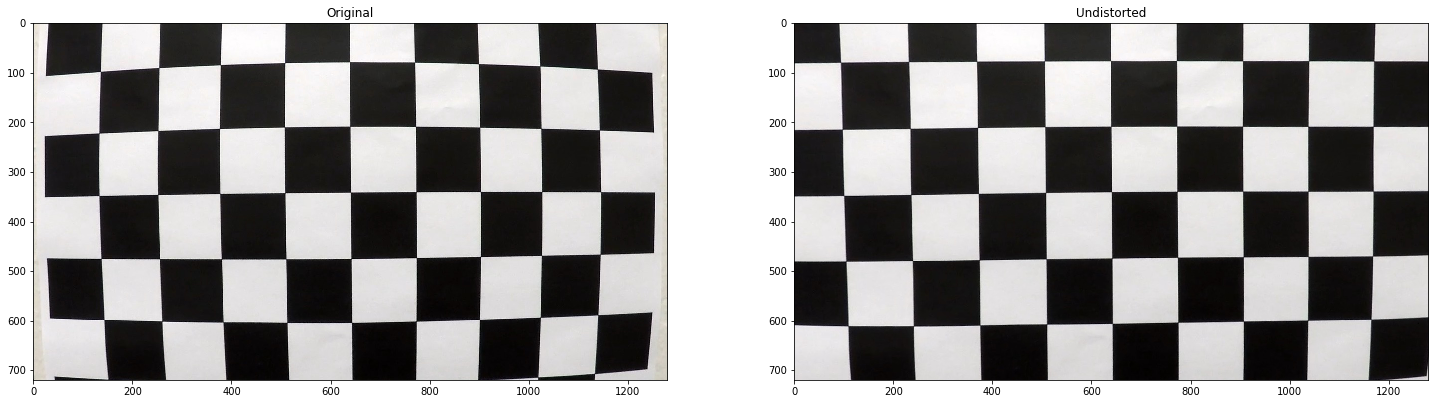

In [84]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
calibration = compute_coefficients(img, obj_points, img_points)
undistorted = undistort(img, calibration)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
ax1.set_title('Original')
ax1.imshow(img)
ax2.set_title('Undistorted')
ax2.imshow(undistorted, cmap='gray')

In [85]:
images = [
    './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg'
]
test_images = []
for fname in images:
    test_images.append(mpimg.imread(fname))
straight_lines1, straight_lines2, test1, test2, test3, test4, test5 = test_images


# Provide an example of a distortion-corrected image.


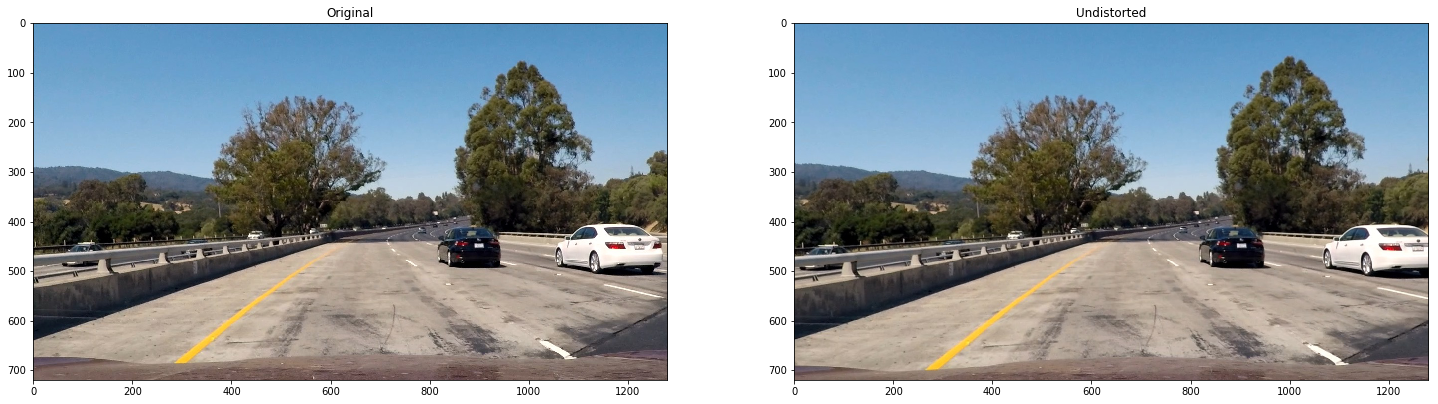

In [86]:
undistorted1 = undistort(test1, calibration)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
ax1.set_title('Original')
ax1.imshow(test1)
ax2.set_title('Undistorted')
ax2.imshow(undistorted1, cmap='gray')

In [87]:
# Helper classes

class Lane():
    def __init__(self):
        self.left = Line()
        self.right = Line()
        self.use_previous_polynomial = False
        self.center_distance = []
        self.width = []

class Line():
    def __init__(self):
        self.allx = None
        self.ally = None
        self.recentx = deque(maxlen=7)
        self.averagex = None     
        self.current_fit = [np.array([False])]
        self.radius = None

lane = Lane()


def threshold(img, s_thresh=(150, 255), sx_thresh=(20, 120)):

    img = np.copy(img)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return (color_binary, combined_binary)


def get_coordinates(img_shape):
    max_x, max_y = (img_shape[1], img_shape[0])
    src = np.float32(
        [[max_x / 2 - 60, max_y / 2 + 100],
        [((max_x / 6) - 0), max_y],
        [(max_x * 5 / 6) + 50, max_y],
        [(max_x / 2 + 60), max_y / 2 + 100]])
    dst = np.float32(
        [[(max_x / 4), 0],
        [(max_x / 4), max_y],
        [(max_x*3/4), max_y],
        [(max_x*3/4), 0]])
    return (src, dst)


def transform(img_shape):
    src, dst = get_coordinates(img_shape)
    M = cv2.getPerspectiveTransform(src, dst)
    return M


def inverse_transform(img_shape):
    src, dst = get_coordinates(img_shape)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return Minv


def warp(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


# Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

Here I used a combination of gradient and color thresholding to generate the following binary image with only lines detected.

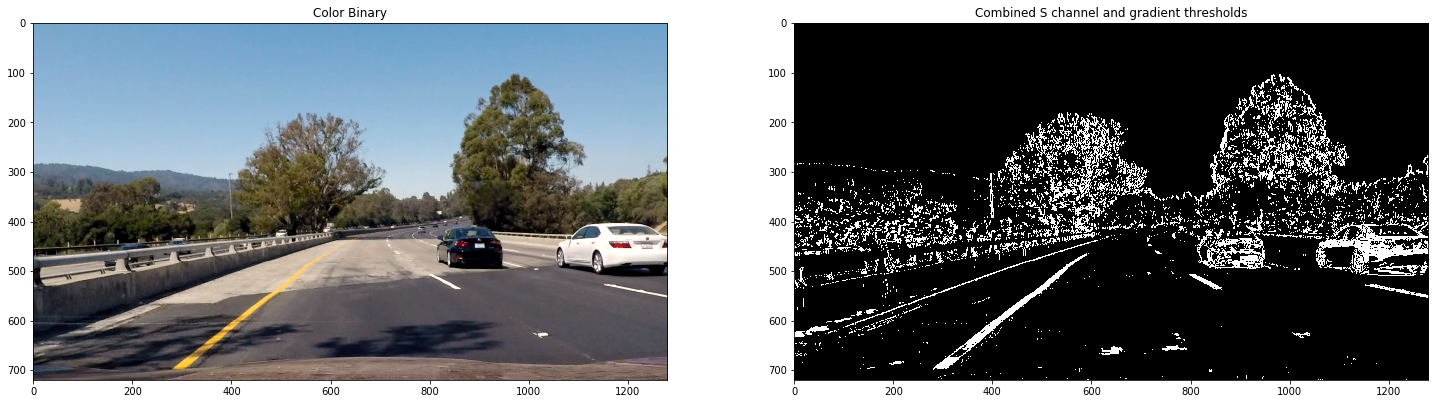

In [88]:
undistorted = undistort(test4, calibration)
color_binary, threshold_image = threshold(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
ax1.set_title('Color Binary')
ax1.imshow(undistorted)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(threshold_image, cmap='gray')

# Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

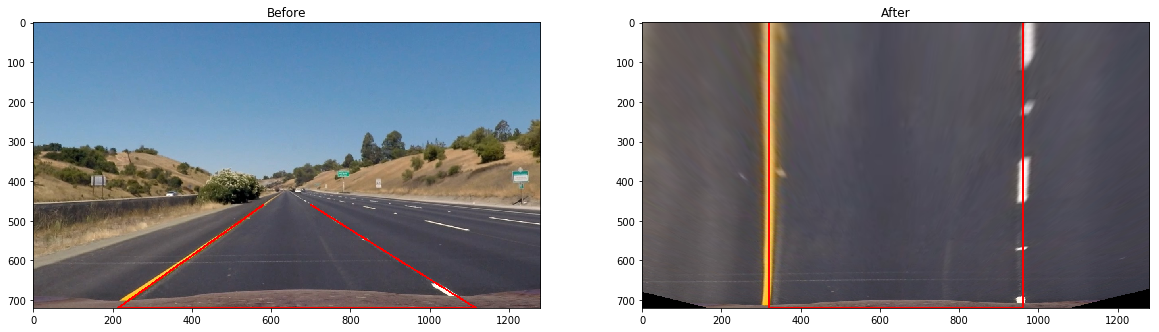

In [89]:
straight_lines = np.copy(straight_lines1)
src, dst = get_coordinates(straight_lines.shape)
M = transform(straight_lines.shape)
Minv = inverse_transform(straight_lines.shape)

undistorted = undistort(straight_lines, calibration)
undistorted_lanes =  cv2.polylines(np.copy(undistorted), np.int32([src]), False, (255,0,0), 3)

warped = warp(undistorted, M)
warped_lanes = cv2.polylines(np.copy(warped), np.int32([dst]), False, (255,0,0), 3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Before')
ax1.imshow(undistorted_lanes)
ax2.set_title('After')
ax2.imshow(warped_lanes, cmap='gray')

In [90]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


def fit_xy_points(left_fit, right_fit):
    plot_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    (A, B, C) = left_fit
    left_fitx = A * plot_y**2 + B * plot_y + C

    (A, B, C) = right_fit
    right_fitx = A * plot_y**2 + B * plot_y + C

    lane.left.allx = left_fitx
    lane.right.allx = right_fitx
    lane.left.ally = plot_y
    lane.right.ally = plot_y


def fit_polynomial(binary_warped, draw=False):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):

        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3)

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    lane.left.current_fit = np.polyfit(lefty, leftx, 2)
    lane.right.current_fit = np.polyfit(righty, rightx, 2)

    left_fit_in_meters = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_in_meters = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    fit_xy_points(lane.left.current_fit, lane.right.current_fit)
    
    if draw:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(lane.left.allx, lane.left.ally, color='yellow')
        plt.plot(lane.right.allx, lane.right.ally, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return out_img

def fit_previous_polynomial(binary_warped):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    (A, B, C) = lane.left.current_fit
    left_lane_inds = ((nonzerox > (A*(nonzeroy**2) + B*nonzeroy + C - margin)) & 
                      (nonzerox < (A*(nonzeroy**2) + B*nonzeroy + C + margin))) 

    (A, B, C) = lane.right.current_fit
    right_lane_inds = ((nonzerox > (A*(nonzeroy**2) + B*nonzeroy + C - margin)) & 
                       (nonzerox < (A*(nonzeroy**2) + B*nonzeroy + C + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    lane.left.current_fit = np.polyfit(lefty, leftx, 2)
    lane.right.current_fit = np.polyfit(righty, rightx, 2)

    fit_xy_points(lane.left.current_fit, lane.right.current_fit)
    
    return


# Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

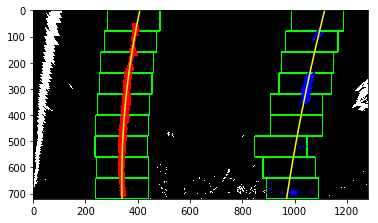

In [91]:
test_image = np.copy(test1)
M = transform(test_image.shape)
undistorted = undistort(test_image, calibration)
color_binary, threshold_image = threshold(undistorted)
binary_warped = warp(threshold_image, M)

out_img = fit_polynomial(binary_warped, draw=True)

In [92]:
def calculate_curve_in_pixels(polynomial_fit, y_eval):
    curve_radius = ((1 + (2*polynomial_fit[0]*y_eval + polynomial_fit[1])**2)**1.5) / np.absolute(2*polynomial_fit[0])
    return curve_radius

def calculate_curve_in_meters(polynomial_fit_in_meters, y_eval):
    curve_radius = ((1 + (2*polynomial_fit_in_meters[0]*y_eval*ym_per_pix + polynomial_fit_in_meters[1])**2)**1.5) / np.absolute(2*polynomial_fit_in_meters[0])
    return curve_radius

def calculate_distance_width(left_polynomial, right_polynomial, max_x, max_y):
    left_pos = left_polynomial[0]*max_y**2 + left_polynomial[1]*max_y + left_polynomial[2]
    right_pos = right_polynomial[0]*max_y**2 + right_polynomial[1]*max_y + right_polynomial[2]
    lane.center_distance.append((left_pos + right_pos - max_x) * xm_per_pix / 2)
    lane.width.append((right_pos - left_pos) * xm_per_pix)

def calculate_lane_analysis(left_polynomial, right_polynomial, img_shape):
    max_x, max_y = (img_shape[1], img_shape[0])

    lane.left.radius = calculate_curve_in_meters(left_polynomial, max_y)
    lane.right.radius = calculate_curve_in_meters(right_polynomial, max_y)
    
    calculate_distance_width(left_polynomial, right_polynomial, max_x, max_y)


# Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [93]:
img_shape = binary_warped.shape
max_x, max_y = (img_shape[1], img_shape[0])

left_radius_in_pixels = calculate_curve_in_pixels(lane.left.current_fit, max_y)
right_radius_in_pixels = calculate_curve_in_pixels(lane.right.current_fit, max_y)
print('Left: {0:.0f}, Right: {1:.0f} in pixels'.format(left_radius_in_pixels, right_radius_in_pixels))

left_radius_in_meters = calculate_curve_in_meters(lane.left.current_fit, max_y)
right_radius_in_meters = calculate_curve_in_meters(lane.right.current_fit, max_y)
calculate_distance_width(lane.left.current_fit, lane.right.current_fit, max_x, max_y)

print('Left: {0:.1f}, Right: {1:.1f} in meters'.format(left_radius_in_meters, right_radius_in_meters))
print('Distance from Center: {0:.2f}m'.format(lane.center_distance[-1]))
print('Lane Width: {0:.2f}m'.format(lane.width[-1]))

Left: 3009, Right: 7548 in pixels
Left: 3196.3, Right: 7970.1 in meters
Distance from Center: 0.08m
Lane Width: 3.33m


In [94]:
def draw_lanes_on_image(base_image, Minv, left_plot_x, right_plot_x, plot_y):

    color_warp = np.zeros_like(base_image).astype(np.uint8)

    left_points = np.array([np.transpose(np.vstack([left_plot_x, plot_y]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_plot_x, plot_y])))])
    points = np.hstack((left_points, right_points))
    
    cv2.fillPoly(color_warp, np.int_([points]), (0, 255, 0))

    warp_result = cv2.warpPerspective(color_warp, Minv, (base_image.shape[1], base_image.shape[0])) 
    result = cv2.addWeighted(base_image, 1, warp_result, 0.3, 0)
    return result


# Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.


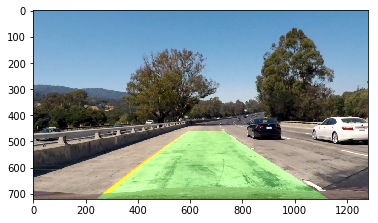

In [95]:
final = draw_lanes_on_image(undistorted, Minv, lane.left.allx, lane.right.allx, lane.left.ally)
plt.imshow(final)

In [99]:
lane = Lane()

min_radius = 250
min_lane_width = 3.0
max_lane_width = 4.0

def recalibrate_test():
    radius_check = lane.left.radius > min_radius and lane.right.radius > min_radius
    width_check = (lane.width[-1] >= min_lane_width) and (lane.width[-1] <= max_lane_width) 
    return radius_check and width_check

def output_info(image, color=(255, 255, 255)):
    cv2.putText(image,'Left Curve: {0:.0f}m, Right Curve: {1:.0f}m'.format(lane.left.radius, lane.right.radius), (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(image,'Lane Width: {0:.2f}m'.format(lane.width[-1]), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(image,'Center Distance: {0:.2f}m'.format(lane.center_distance[-1]), (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

def update_smooth_fit():
    lane.left.recentx.append(lane.left.allx)
    lane.left.averagex = np.average(lane.left.recentx, axis=0)
    lane.right.recentx.append(lane.right.allx)
    lane.right.averagex = np.average(lane.right.recentx, axis=0)
    
def lane_line_pipeline(image):
    undistorted = undistort(image, calibration)
    color_binary, threshold_image = threshold(undistorted)
    binary_warped = warp(threshold_image, M)
    
    if (lane.use_previous_polynomial):
        fit_previous_polynomial(binary_warped)
    else:
        fit_polynomial(binary_warped)
        
    img_shape = binary_warped.shape
    calculate_lane_analysis(lane.left.current_fit, lane.right.current_fit, img_shape)
    test_passed = recalibrate_test()

    binary_warped_frame = np.dstack((binary_warped, binary_warped, binary_warped))*255
    output_info(out_img, color=(255, 0, 0))
    
    if test_passed:
        lane.use_previous_polynomial = True
        update_smooth_fit()
        result = draw_lanes_on_image(undistorted, Minv, lane.left.averagex, lane.right.averagex, lane.left.ally)
        output_info(result)
    else:
        lane.use_previous_polynomial = False
        result = draw_lanes_on_image(undistorted, Minv, lane.left.averagex, lane.right.averagex, lane.left.ally)
        output_info(result)

    return result

# Provide a link to your final video output.

In [100]:
lane = Lane()

input_filename = 'project_video.mp4'
output_filename = 'output_videos/' + input_filename

video_file = VideoFileClip(input_filename)

output_clip = video_file.fl_image(lane_line_pipeline)
%time output_clip.write_videofile(output_filename, audio=False)


[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [04:02<00:00,  5.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 6min 22s, sys: 1min 12s, total: 7min 34s
Wall time: 4min 4s


# Harder challenge video

In [101]:
lane = Lane()

input_filename = 'harder_challenge_video.mp4'
output_filename = 'output_videos/' + input_filename

video_file = VideoFileClip(input_filename)

output_clip = video_file.fl_image(lane_line_pipeline)
%time output_clip.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [04:19<00:00,  4.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

CPU times: user 6min 56s, sys: 1min 11s, total: 8min 8s
Wall time: 4min 22s
